In [1]:
import functools as fn
import datetime
import math
import time
import pandas as pd
import numpy as np
import scipy.stats as scs

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearnex import patch_sklearn ## Must run patch before importing other sklearn functions!!!
patch_sklearn()
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import os
os.add_dll_directory('C:\Aorda\PSG\lib')
import psgpython
import xgboost as xgb

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Loading clean data 

df = pd.read_feather('clean_features_30e.f')


In [3]:
column_names = ['ask_price', 'bid_price', 'ask_volume', 'bid_volume',
       'mid_price', 'spread', 'dPask_dt', 'dPbid_dt', 'dVask_dt', 'dVbid_dt',
       'avg_trade_price_10ms', 'avg_trade_price_100ms', 'avg_trade_price_1s',
       'avg_trade_price_10s', 'avg_trade_volume_10ms',
       'avg_trade_volume_100ms', 'avg_trade_volume_1s',
       'avg_trade_volume_10s']

classes_names_1 = ['midup', 'middown', 'mideq']
classes_names_2 = [ 'spreadup', 'spreaddown','spreadeq']

In [4]:
X = df[column_names] # design matrix (feature matrix)

In [5]:
Y = df[classes_names_1] # mid-price classes
Y_2 = df[classes_names_2] # spread-price classes

In [6]:
Y['midup'] = Y['midup']*1
Y['middown'] = Y['middown']*2
Y['mideq'] = Y['mideq']*3

C:\Users\tonma\AppData\Local\Temp\ipykernel_26288\593290779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['midup'] = Y['midup']*1
C:\Users\tonma\AppData\Local\Temp\ipykernel_26288\593290779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['middown'] = Y['middown']*2
C:\Users\tonma\AppData\Local\Temp\ipykernel_26288\593290779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [7]:
Y = Y.max(axis=1) # converted mid-price classes

In [8]:
# Frequency distribution of classes
train_outcome = pd.crosstab(index = Y,  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome

col_0,count
row_0,
1,177806
2,164885
3,45223


In [9]:
# Visualizing Outcome Distribution 
temp = Y.value_counts()
df_plt = pd.DataFrame({'labels': classes_names_1, 'values': temp.values})


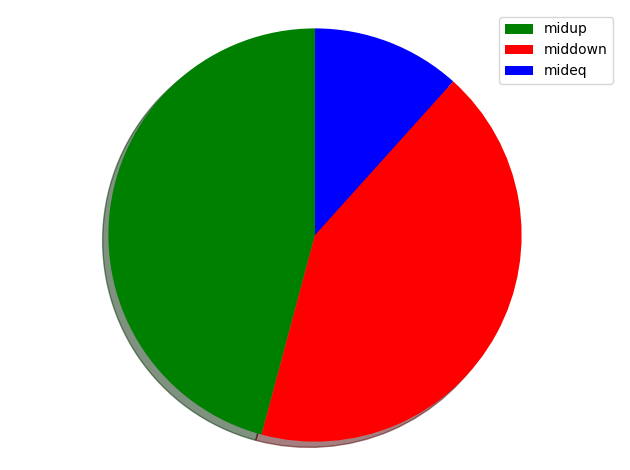

In [10]:
labels = df_plt['labels']
sizes = df_plt['values']
colors = ['green', 'red', 'blue']

patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [11]:
Y = Y.apply(lambda x: 1 if x==1 else 0) # midup = 1, (middown,mideq) = (0,0)

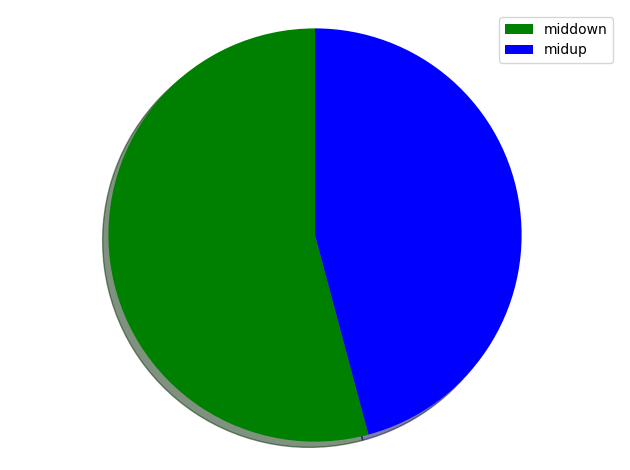

In [12]:
# Visualizing the New Outcome Distribution 
temp_new = Y.value_counts()
df_plt = pd.DataFrame({'labels': ['middown','midup'], 'values': temp_new.values})

labels = df_plt['labels']
sizes = df_plt['values']
colors = ['green', 'blue']

patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [13]:
df_spline = pd.DataFrame()
df_spline[X.columns] = X
df_spline['benchmark'] = Y

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state = 0, stratify=Y)

In [15]:
df_transformed = pd.DataFrame()

In [17]:
for name in X.columns:
    x_1 = X_train[name].to_numpy()  # index = 1 corresponds to train data, index = 2 corresponds to all data
    x_2 = X[name].to_numpy()
    x_1 = np.reshape(x_1,(len(X_train),1))
    x_2 = np.reshape(x_2,(len(X),1))
    bench_1 = y_train.to_numpy()
    bench_2 = Y.to_numpy()
    mat_sc_1 = np.column_stack((x_1, bench_1))
    mat_sc_2 = np.column_stack((x_2, bench_2))
    header = ["x%d" % (i) for i in range(1,mat_sc_1.shape[1])]
    matrix_DTI_spl_1 = [header + ['scenario_benchmark'], mat_sc_1]
    matrix_DTI_spl_2 = [header + ['scenario_benchmark'], mat_sc_2]
    parameters_body = np.reshape(np.array([3,5,3],dtype='float64'),(3,1))
    matrix_parameters_5_pieces = [header, parameters_body]
    
# Optimizing spline coeffs using training data
    allowExternal = True
    suppressMessages = False
    problem_name = "spline_test"
    problem_statement = "maximize\n\
    logexp_sum(spline_sum(matrix_parameters_5_pieces, matrix_DTI_spl_1))"

    problem_dictionary = {'problem_name':problem_name, 'problem_statement':problem_statement, 'matrix_DTI_spl_1':matrix_DTI_spl_1,
    'matrix_parameters_5_pieces':matrix_parameters_5_pieces}

    res = psgpython.psg_solver(problem_dictionary, allowExternal, suppressMessages)
    
# Transforming all the data
    allowExternal = True
    suppressMessages = False
    problem_name = "spline_test_1"
    problem_statement = "calculate\n\
    Point: point_problem_2\n\
    logistic(spline_sum(matrix_parameters_5_pieces, matrix_DTI_spl_2))"

    problem_dictionary = {'problem_name':problem_name, 'problem_statement':problem_statement, 'matrix_DTI_spl_2':matrix_DTI_spl_2,
    'matrix_parameters_5_pieces':matrix_parameters_5_pieces, 'point_problem_2': res['point_problem_1']}

    res_2 = psgpython.psg_solver(problem_dictionary, allowExternal, suppressMessages)

    df_transformed[name] = res_2['vector_logistic']





Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_parameters_5_pieces was read
100% of matrix_dti_spl_1 was read
Start optimization
Ext.iteration=0  Objective=-.693147180563E+00  Residual=0.000000000000E+00
Ext.iteration=24  Objective=-.689412650982E+00  Residual=0.000000000000E+00
Ext.iteration=45  Objective=-.689412616258E+00  Residual=0.000000000000E+00
Ext.iteration=65  Objective=-.689412538312E+00  Residual=0.000000000000E+00
Ext.iteration=87  Objective=-.689411963824E+00  Residual=0.000000000000E+00
Ext.iteration=109  Objective=-.689408223893E+00  Residual=0.000000000000E+00
Ext.iteration=130  Objective=-.689391725284E+00  Residual=0.000000000000E+00
Ext.iteration=153  Objective=-.689373760567E+00  Residual=0.000000000000E+00
Ext.iteration=168  Objective=-.689372910846E+00  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = -0.689372910846 

Start optimization
Ext.iteration=0  Objective=-.693147180563E+00  Residual=0.000000000000E+00
Ext.iteration=24  Objective=-.689409684200E+00  Residual=0.000000000000E+00
Ext.iteration=35  Objective=-.689409547667E+00  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = -0.689409547667 [2.804039989091E-08]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = optimal
Timing: data_loading_time = 0.07, preprocessing_time = 0.44, solving_time = 3.24
Variables: optimal_point = point_problem_1
Objective: objective = -0.689409547667 [2.804039989091E-08]
Constraint: constraint_for_smoothing_spline = -2.131628207280E-14 [ 2.131628207280E-14]
Function: logexp_sum(spline_sum(matrix_parameters_5_pieces,matrix_dti_spl_1)) = -6.894095476667E-01
OK. Solver Finished

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_parameters_5_

Ext.iteration=224  Objective=-.688001480145E+00  Residual=0.000000000000E+00
Ext.iteration=249  Objective=-.687814738802E+00  Residual=0.000000000000E+00
Ext.iteration=273  Objective=-.687757547959E+00  Residual=0.000000000000E+00
Ext.iteration=298  Objective=-.687550710044E+00  Residual=0.000000000000E+00
Ext.iteration=323  Objective=-.687244058164E+00  Residual=0.000000000000E+00
Ext.iteration=347  Objective=-.687226119006E+00  Residual=0.000000000000E+00
Ext.iteration=371  Objective=-.687224129003E+00  Residual=0.000000000000E+00
Ext.iteration=396  Objective=-.687223851242E+00  Residual=0.000000000000E+00
Ext.iteration=421  Objective=-.687223703080E+00  Residual=0.000000000000E+00
Ext.iteration=430  Objective=-.687223685537E+00  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = -0.687223685537 [3.198920739411E-08]
Solver has normally finished. Solution was saved.
Problem: problem_1, solutio

Start optimization
Ext.iteration=0  Objective=-.693147180563E+00  Residual=0.000000000000E+00
Ext.iteration=25  Objective=-.689662092493E+00  Residual=0.000000000000E+00
Ext.iteration=49  Objective=-.689505733744E+00  Residual=0.000000000000E+00
Ext.iteration=73  Objective=-.689481647825E+00  Residual=0.000000000000E+00
Ext.iteration=97  Objective=-.689480081200E+00  Residual=0.000000000000E+00
Ext.iteration=121  Objective=-.689478091116E+00  Residual=0.000000000000E+00
Ext.iteration=145  Objective=-.689477654904E+00  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = -0.689477654904 [3.270365056540E-08]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = optimal
Timing: data_loading_time = 0.06, preprocessing_time = 0.45, solving_time = 12.55
Variables: optimal_point = point_problem_1
Objective: objective = -0.689477654904 [3.270365056540E-08]
Constraint: co

Start optimization
Ext.iteration=0  Objective=-.693147180563E+00  Residual=0.000000000000E+00
Ext.iteration=25  Objective=-.688675892998E+00  Residual=0.000000000000E+00
Ext.iteration=49  Objective=-.688628302867E+00  Residual=0.000000000000E+00
Ext.iteration=73  Objective=-.688622643015E+00  Residual=0.000000000000E+00
Ext.iteration=97  Objective=-.688622028941E+00  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = -0.688622028941 [3.056303587989E-08]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = optimal
Timing: data_loading_time = 0.06, preprocessing_time = 0.45, solving_time = 8.45
Variables: optimal_point = point_problem_1
Objective: objective = -0.688622028941 [3.056303587989E-08]
Constraint: constraint_for_smoothing_spline = -8.718835386740E-15 [ 8.718835386740E-15]
Function: logexp_sum(spline_sum(matrix_parameters_5_pieces,matrix_dti_spl_1)) = -

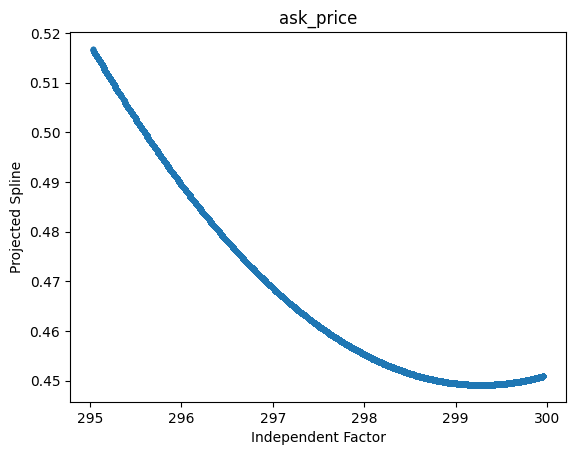

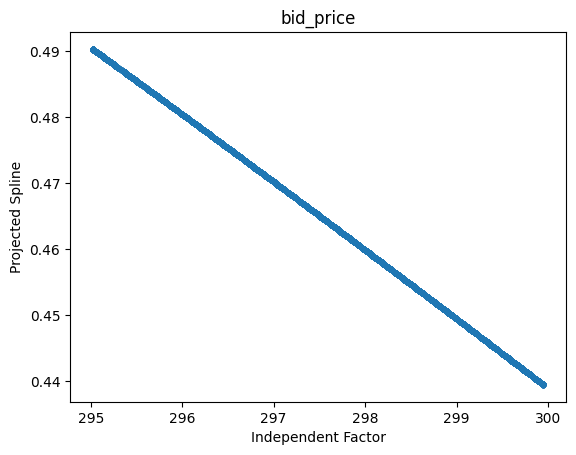

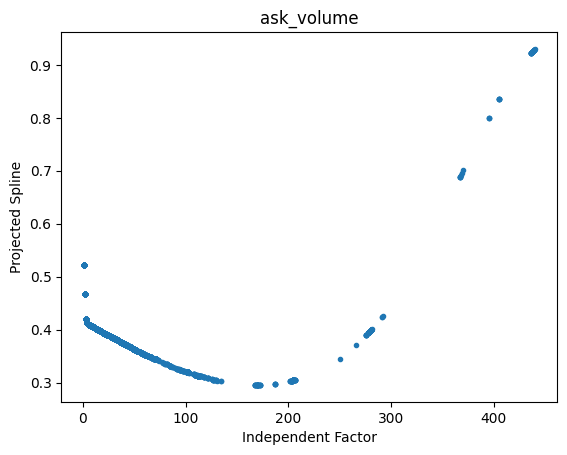

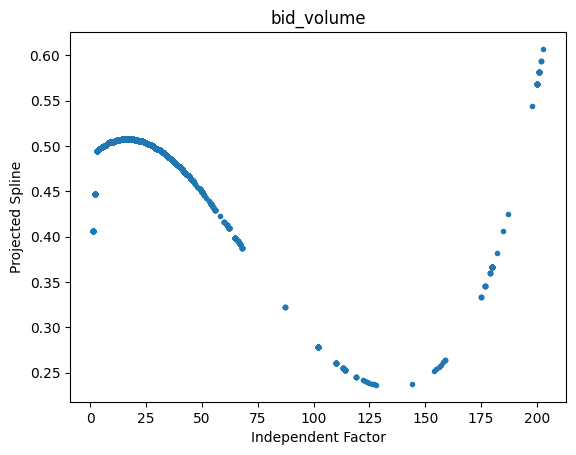

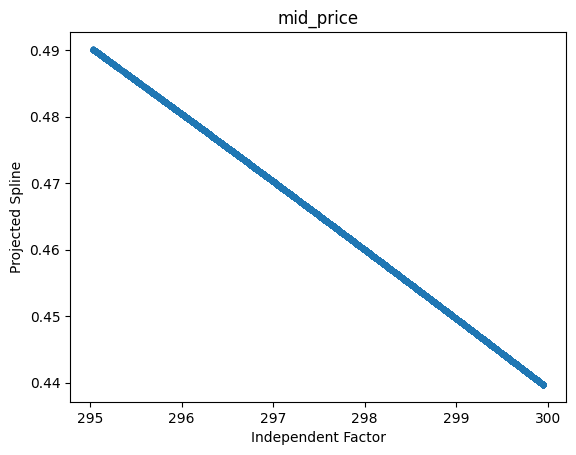

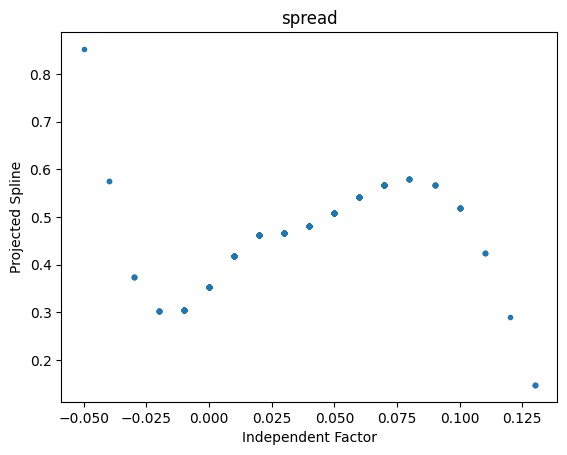

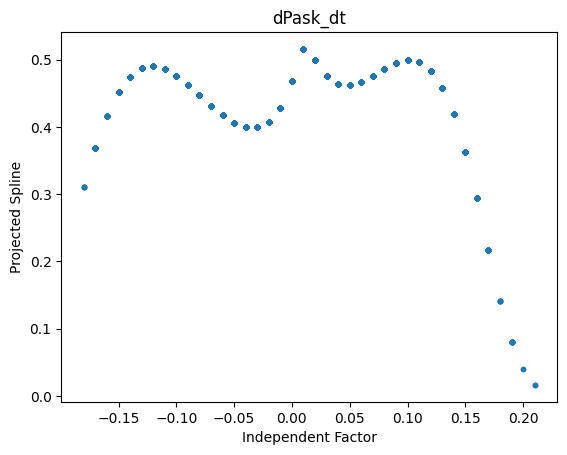

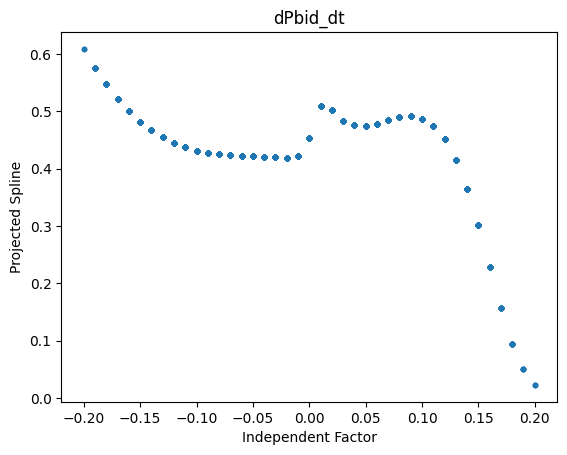

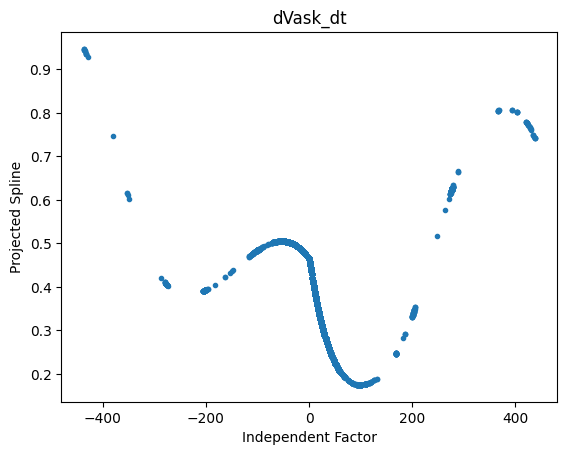

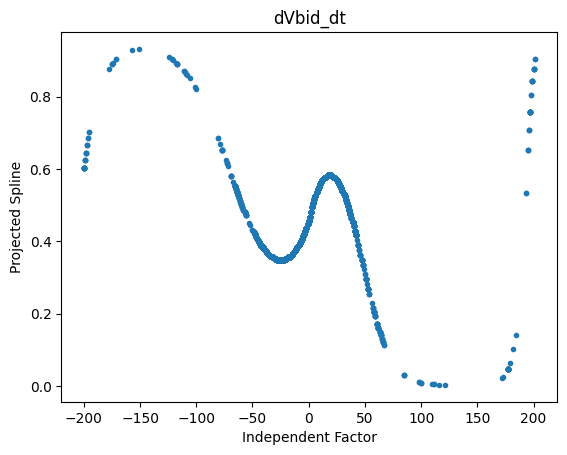

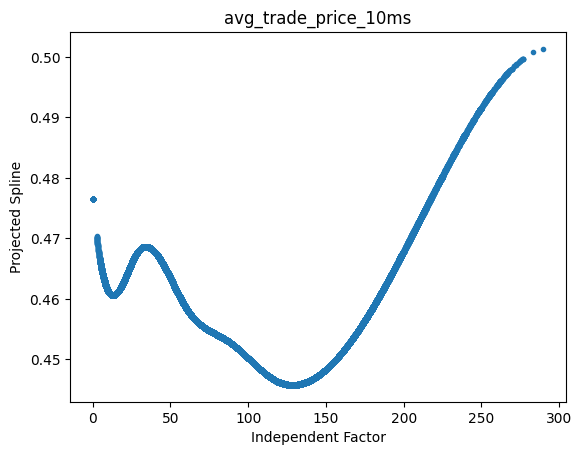

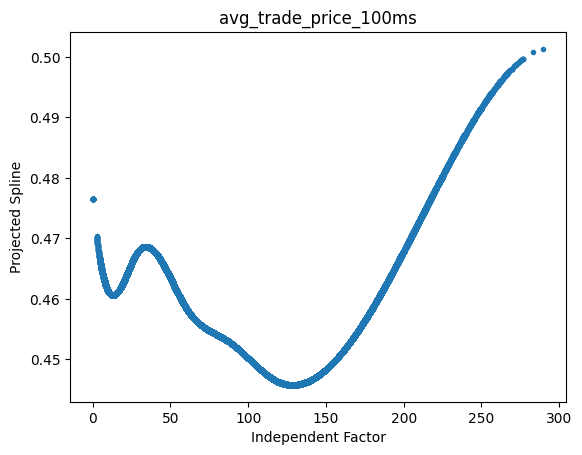

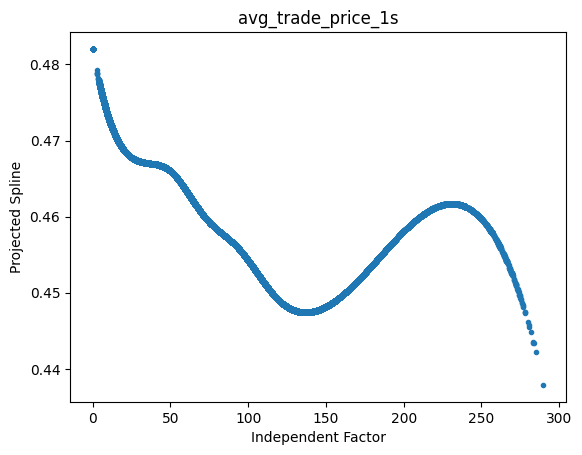

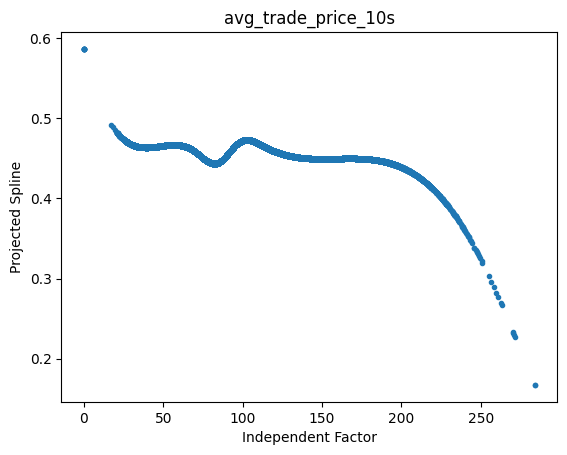

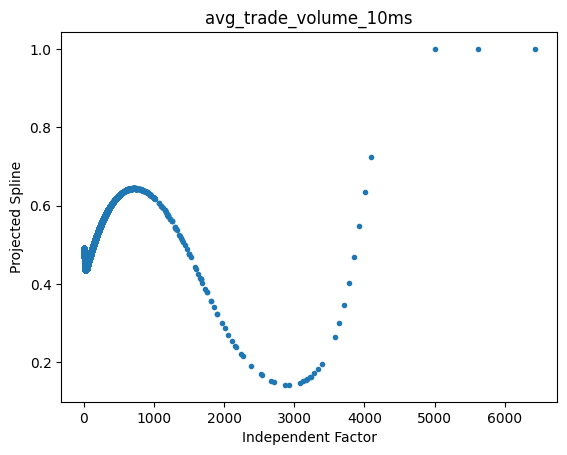

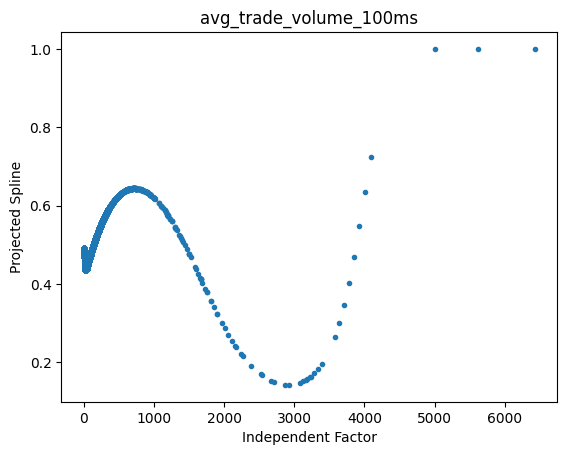

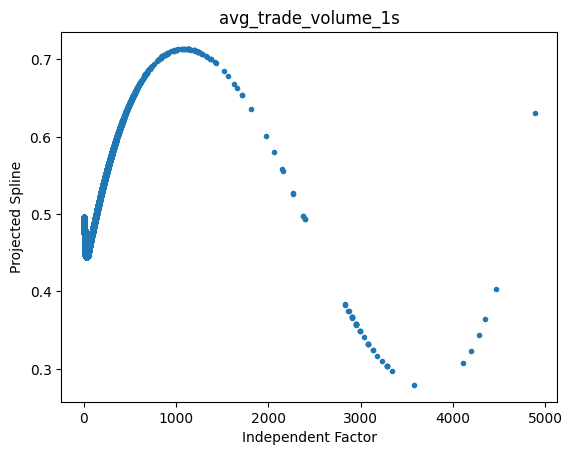

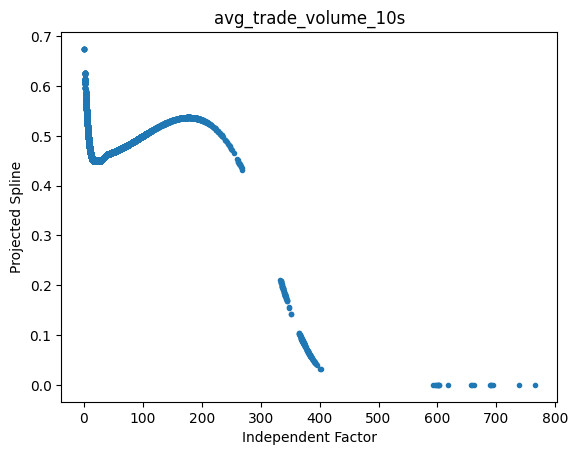

In [42]:
# Saving plotted splines
for name in column_names:
    df_plotting_1 = pd.DataFrame()
    df_plotting_1['x'] = X[name]  # put the name of any feature here
    df_plotting_1['y'] = df_transformed[name]  # put the name of the same feature here
    df_plotting_1 = df_plotting_1.sort_values(by = 'x', ascending = True)

    plt.figure()
    plt.plot(df_plotting_1['x'],df_plotting_1['y'], '.')
    plt.xlabel('Independent Factor')
    plt.ylabel('Projected Spline')
    plt.title(name)  # put the name of the same feature here as a title
    plt.savefig(name+'.png')



In [20]:
df_transformaed = X

In [21]:
# Splitting transformed data 
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state = 0, stratify=Y)

In [22]:
# Fitting Logistic Regression
logreg = LogisticRegression(max_iter=100000, random_state = 0, penalty = 'l2')
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=100000, random_state=0)

In [23]:
y_pred = logreg.predict(X_test)
print(metrics.classification_report(y_pred = y_pred, y_true = y_test))

              precision    recall  f1-score   support

           0       0.54      0.99      0.70     42022
           1       0.45      0.01      0.03     35561

    accuracy                           0.54     77583
   macro avg       0.50      0.50      0.36     77583
weighted avg       0.50      0.54      0.39     77583



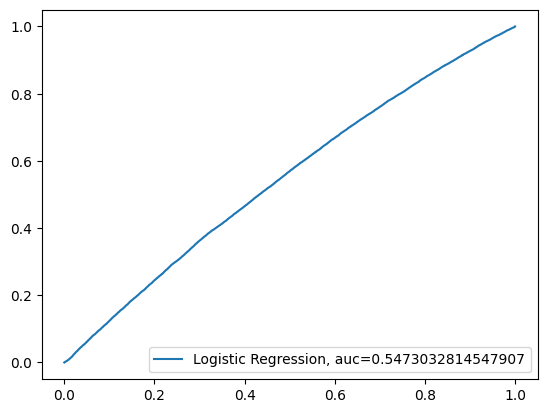

In [24]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.legend(loc=4)
# plt.savefig('ORC_and_AUC.pdf')
plt.show()

In [25]:
# Fitting the Random Forest

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 8)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [10, 15], 'min_samples_leaf': [2, 4, 6], 'bootstrap': [True, False]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 4, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  29.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  23.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  22.8s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=500; total time=  23.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=700; total time=  36.6s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=700; total time=  35.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=7

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=15,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800]},
                   random_state=42, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [29]:
# Random Forest with RandomSearch
final_model = rf_random.best_estimator_
y_pred_best = final_model.predict(X_test)

In [30]:
# Random Forest for a random parameter setting
clf = RandomForestClassifier(min_samples_leaf = 30,n_estimators = 100, criterion = 'entropy', random_state = 42, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

c:\users\tonma\python lectures\ams 520\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [31]:
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

[[33876  8146]
 [16382 19179]]


              precision    recall  f1-score   support

           0       0.67      0.81      0.73     42022
           1       0.70      0.54      0.61     35561

    accuracy                           0.68     77583
   macro avg       0.69      0.67      0.67     77583
weighted avg       0.69      0.68      0.68     77583



In [32]:
print(confusion_matrix(y_test,y_pred_best))
print("\n")
print(classification_report(y_test,y_pred_best))

[[36388  5634]
 [ 8410 27151]]


              precision    recall  f1-score   support

           0       0.81      0.87      0.84     42022
           1       0.83      0.76      0.79     35561

    accuracy                           0.82     77583
   macro avg       0.82      0.81      0.82     77583
weighted avg       0.82      0.82      0.82     77583



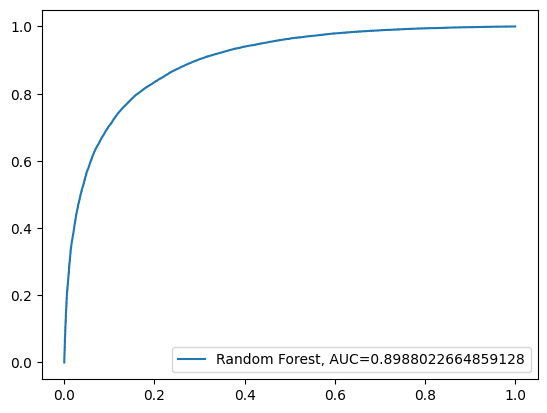

In [37]:
y_pred_proba_1 = final_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_1)
auc = metrics.roc_auc_score(y_test, y_pred_proba_1)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))
plt.legend(loc=4)
# plt.savefig('ORC_and_AUC.pdf')
plt.show()